PART 02

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the gridworld size and discount factor
grid_size = 5
gamma = 0.95
alpha = 0.1  # Learning rate
epsilon = 0.1  # Epsilon for epsilon-greedy policy

# Define transitions for special squares
transitions = {}
transitions[(0, 1)] = [(5, (4, 2))]   # Blue -> Red
transitions[(0, 4)] = [(2.5, (4, 2)), (2.5, (4, 4))]  # Green -> Red or Yellow

# Define terminal states
terminal_states = [(2, 0), (4, 0), (2, 4)]  # Black squares are terminal states

# Define the four possible actions
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
action_symbols = {(-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'}
action_indices = {(-1, 0): 0, (1, 0): 1, (0, -1): 2, (0, 1): 3}

1.1 Monte Carlo method with exploring starts

In [2]:
MAX_STEPS = 100  # Maximum number of steps per episode
np.random.seed(42)  # Set random seed for reproducibility
random.seed(42)

# Function to get the next state and reward
def get_next_state_reward(state, action):
    if state in terminal_states:
        return (0, state)  # No reward, remain in terminal state
    if state in transitions:
        transition = transitions[state]
        idx = np.random.choice(len(transition))  # Choose one of the possible transitions
        return transition[idx]
    else:
        next_state = (state[0] + action[0], state[1] + action[1])
        if next_state[0] < 0 or next_state[0] >= grid_size or next_state[1] < 0 or next_state[1] >= grid_size:
            return (-0.5, state)  # Stepping off the grid
        return (-0.2, next_state)  # Normal move

# Initialize policy and value function
policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)  # Equiprobable policy
Q = np.zeros((grid_size, grid_size, len(actions)))  # Initialize action-value function
Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]  # Store returns for each state-action pair

# Function to generate an episode using exploring starts
def generate_episode(policy):
    S0 = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
    A0 = random.choice(actions)
    episode = [(S0, A0, 0)]  # (state, action, reward)
    
    state = S0
    action = A0
    steps = 0  # Add a step counter to prevent infinite loops
    while state not in terminal_states and steps < MAX_STEPS:  # Limit the number of steps to prevent infinite loops
        reward, next_state = get_next_state_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
        if state in terminal_states:
            break
        action = random.choices(actions, policy[state[0], state[1]])[0]
        steps += 1  # Increment the step counter
    
    return episode

# Monte Carlo method with exploring starts
def monte_carlo_es(policy, Q, Returns, num_episodes):
    avg_returns_per_episode = []
    for episode_num in range(num_episodes):
        episode = generate_episode(policy)
        G = 0  # Initialize return
        visited = set()  # Track visited state-action pairs
        
        for t in reversed(range(len(episode) - 1)):
            St, At, Rt = episode[t]
            G = gamma * G + episode[t + 1][2]  # episode[t + 1][2] is the reward
            state_action = (St, actions.index(At))
            if state_action not in visited:
                state_index = St[0] * grid_size + St[1]
                Returns[state_index][actions.index(At)].append(G)
                Q[St[0], St[1], actions.index(At)] = np.mean(Returns[state_index][actions.index(At)])
                visited.add(state_action)
        
        # Calculate and store the average return of the current episode
        avg_returns_per_episode.append(G)
        
        # Update policy
        for i in range(grid_size):
            for j in range(grid_size):
                best_action = np.argmax(Q[i, j])
                policy[i, j] = np.eye(len(actions))[best_action]
    
    return policy, Q

# Perform Monte Carlo with exploring starts
optimal_policy_es, optimal_Q_es = monte_carlo_es(policy, Q, Returns, num_episodes=20000)

# Print the optimal policy using text
print("Optimal Policy with Exploring Starts:")
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        best_action_idx = np.argmax(optimal_policy_es[i, j])
        best_action = actions[best_action_idx]
        row.append(action_symbols[best_action])
    print(" ".join(row))


Optimal Policy with Exploring Starts:
→ ↑ ← ← →
→ ↑ ← → ↑
↑ ↑ ↑ ← ↑
→ ↑ ↑ ← ←
↑ ↓ ↑ ↑ ↑


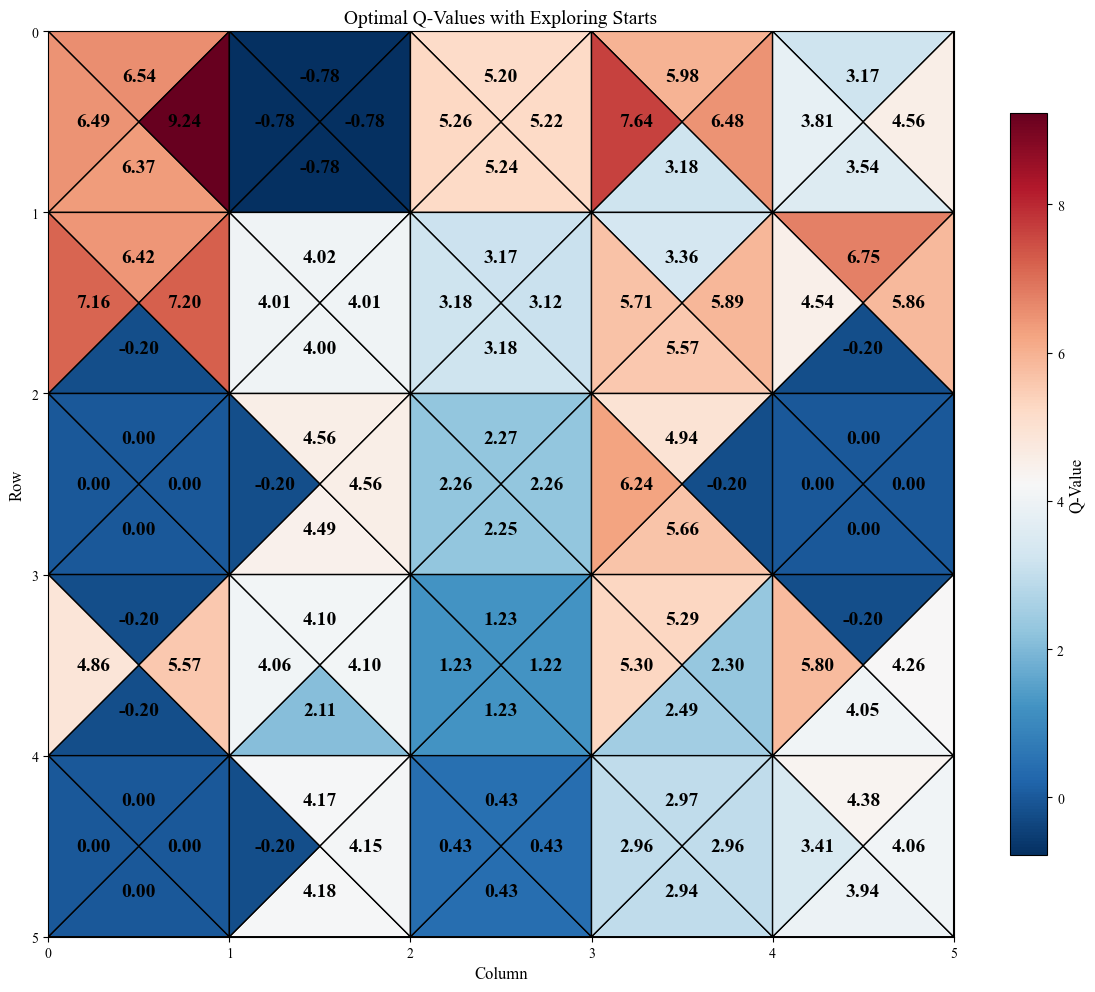

In [3]:
# Function to plot Q-values as heatmap with triangular divisions
def plot_q_values(Q, title="Q-Values Heatmap"):
    plt.rcParams['font.family'] = 'Times New Roman'
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Get min/max Q-values for color normalization
    vmin, vmax = np.min(Q), np.max(Q)
    
    # Create colormap
    cmap = plt.cm.RdBu_r
    
    # Plot each cell divided into 4 triangles
    for i in range(grid_size):
        for j in range(grid_size):
            # Get Q-values for this state [up, down, left, right]
            q_vals = Q[i, j, :]
            
            # Define triangles: each triangle is defined by 3 points
            # Top triangle (up action)
            top_triangle = np.array([[j, i], [j+0.5, i+0.5], [j+1, i]])
            # Bottom triangle (down action)  
            bottom_triangle = np.array([[j, i+1], [j+0.5, i+0.5], [j+1, i+1]])
            # Left triangle (left action)
            left_triangle = np.array([[j, i], [j+0.5, i+0.5], [j, i+1]])
            # Right triangle (right action)
            right_triangle = np.array([[j+1, i], [j+0.5, i+0.5], [j+1, i+1]])
            
            triangles = [top_triangle, bottom_triangle, left_triangle, right_triangle]
            
            # Plot each triangle with its corresponding Q-value color
            for k, (triangle, q_val) in enumerate(zip(triangles, q_vals)):
                # Normalize Q-value for color mapping
                norm_val = (q_val - vmin) / (vmax - vmin) if vmax != vmin else 0.5
                color = cmap(norm_val)
                
                # Create and add triangle patch
                triangle_patch = plt.Polygon(triangle, facecolor=color, 
                                           edgecolor='black', linewidth=1)
                ax.add_patch(triangle_patch)
            
            # Add Q-value text in each triangle
            # Top triangle (up action)
            ax.text(j+0.5, i+0.25, f'{q_vals[0]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            # Bottom triangle (down action)
            ax.text(j+0.5, i+0.75, f'{q_vals[1]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            # Left triangle (left action)
            ax.text(j+0.25, i+0.5, f'{q_vals[2]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
            # Right triangle (right action)
            ax.text(j+0.75, i+0.5, f'{q_vals[3]:.2f}', 
                   ha='center', va='center', fontsize=14, fontweight='bold', color='black')
    
    # Set up the plot
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(grid_size + 1))
    ax.set_yticks(np.arange(grid_size + 1))
    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # Invert y-axis to match matrix indexing
    ax.invert_yaxis()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('Q-Value', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Plot the Q-values
plot_q_values(optimal_Q_es, "Optimal Q-Values with Exploring Starts")

1.2 Monte Carlo method without Exploring Starts using ϵ-soft approach

In [4]:
np.random.seed(42)
random.seed(42)

# Function to get the next state and reward
def get_next_state_reward(state, action):
    if state in terminal_states:
        return (0, state)
    if state in transitions:
        transition = transitions[state]
        idx = np.random.choice(len(transition))
        return transition[idx]
    else:
        next_state = (state[0] + action[0], state[1] + action[1])
        if next_state[0] < 0 or next_state[0] >= grid_size or next_state[1] < 0 or next_state[1] >= grid_size:
            return (-0.5, state)  # Stepping off the grid
        return (-0.2, next_state)  # Normal move

# Initialize policy and value function
policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)  # ϵ-soft policy
Q = np.zeros((grid_size, grid_size, len(actions)))  # Initialize action-value function
Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]  # Store returns for each state-action pair

# Function to generate an episode following the epsilon-soft policy
def generate_episode(policy):
    state = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
    episode = []
    
    steps = 0  # Add a step counter to prevent infinite loops
    while state not in terminal_states and steps < 100:  # Limit the number of steps to prevent infinite loops
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Random action with probability epsilon
        else:
            action = random.choices(actions, policy[state[0], state[1]])[0]  # Greedy action with probability 1-epsilon
        reward, next_state = get_next_state_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
        steps += 1  # Increment the step counter
    
    return episode

# Monte Carlo method with epsilon-soft policy
def monte_carlo_eps_soft(policy, Q, Returns, num_episodes):
    for episode_num in range(num_episodes):
        episode = generate_episode(policy)
        G = 0  # Initialize return
        visited = set()  # Track visited state-action pairs
        
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            state_action = (state, actions.index(action))
            if state_action not in visited:
                state_index = state[0] * grid_size + state[1]
                Returns[state_index][actions.index(action)].append(G)
                Q[state[0], state[1], actions.index(action)] = np.mean(Returns[state_index][actions.index(action)])
                visited.add(state_action)
                
                best_action = np.argmax(Q[state[0], state[1]])
                for a in range(len(actions)):
                    if a == best_action:
                        policy[state[0], state[1], a] = 1 - epsilon + epsilon / len(actions)
                    else:
                        policy[state[0], state[1], a] = epsilon / len(actions)
    
    return policy, Q

# Initialize policy and value function for epsilon-soft
policy_eps_soft = np.ones((grid_size, grid_size, len(actions))) / len(actions)
Q_eps_soft = np.zeros((grid_size, grid_size, len(actions)))
returns_eps_soft = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]

# Perform Monte Carlo with epsilon-soft policy
optimal_policy_eps_soft, optimal_Q_eps_soft = monte_carlo_eps_soft(policy_eps_soft, Q_eps_soft, returns_eps_soft, num_episodes=20000)

# Print the optimal policy using text
action_symbols = {(-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'}
print("Optimal Policy with Epsilon-Soft Policy:")
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        best_action_idx = np.argmax(optimal_policy_eps_soft[i, j])
        best_action = actions[best_action_idx]
        row.append(action_symbols[best_action])
    print(" ".join(row))


Optimal Policy with Epsilon-Soft Policy:
→ ↓ ← ← ↓
↑ → ← ↑ ←
↑ ↑ ↑ ↑ ↑
→ ↑ ↑ ↑ ←
↑ ↑ ↓ ↑ ↑


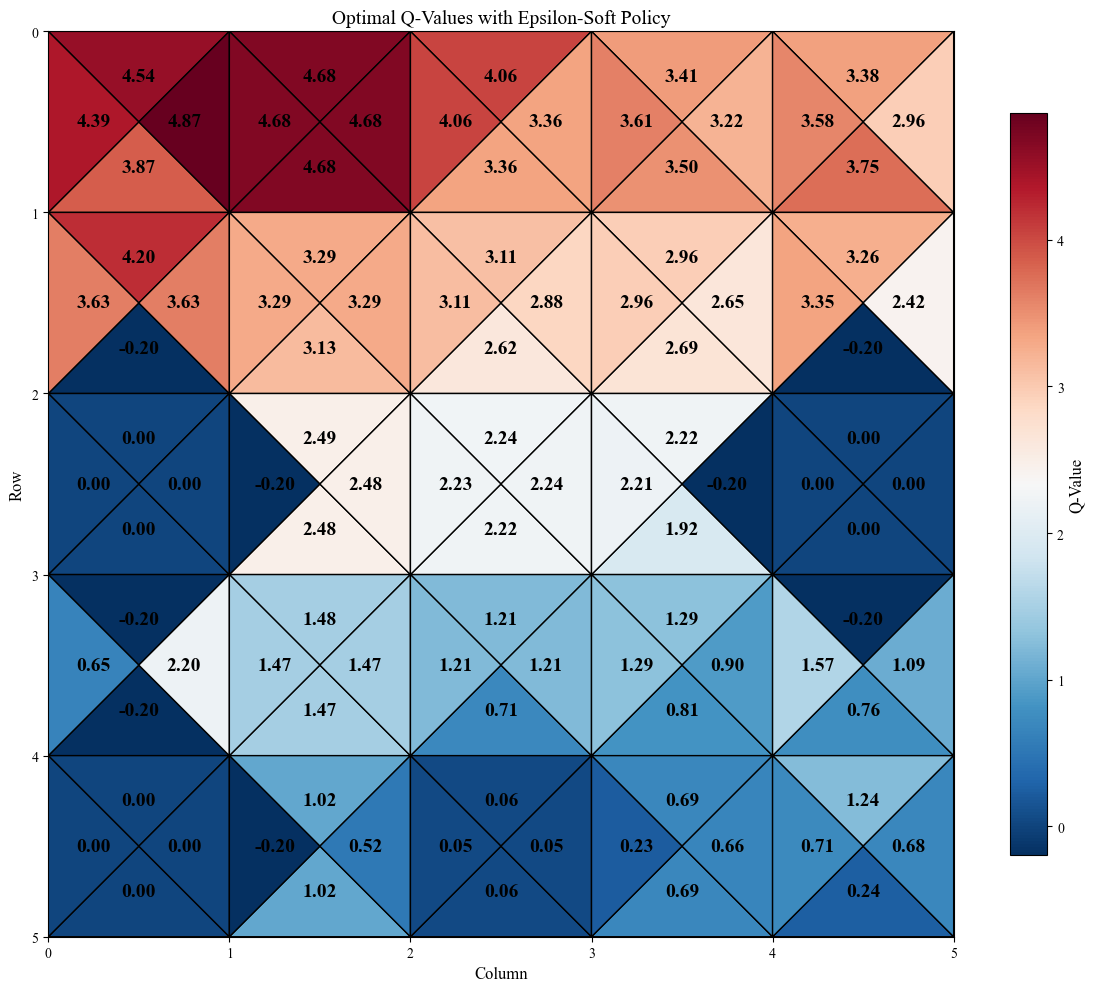

In [5]:
# Plot the Q-values
plot_q_values(optimal_Q_eps_soft, "Optimal Q-Values with Epsilon-Soft Policy")

2.1 Behaviour policy with equiprobable moves to learn an optimal policy.

In [6]:
np.random.seed(42)
random.seed(42)

# Function to get the next state and reward
def get_next_state_reward(state, action):
    if state in terminal_states:
        return (0, state)
    if state in transitions:
        transition = transitions[state]
        idx = np.random.choice(len(transition))
        return transition[idx]
    else:
        next_state = (state[0] + action[0], state[1] + action[1])
        if next_state[0] < 0 or next_state[0] >= grid_size or next_state[1] < 0 or next_state[1] >= grid_size:
            return (-0.5, state)  # Stepping off the grid
        return (-0.2, next_state)  # Normal move

# Initialize the behavior policy and value function
behavior_policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)  # Equiprobable policy
target_policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)  # Initial target policy
Q = np.zeros((grid_size, grid_size, len(actions)))  # Initialize action-value function
Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]  # Store returns for each state-action pair

# Function to generate an episode following the behavior policy
def generate_episode(policy):
    state = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
    episode = []
    
    steps = 0  # Add a step counter to prevent infinite loops
    while state not in terminal_states and steps < 100:  # Limit the number of steps to prevent infinite loops
        action = random.choices(actions, policy[state[0], state[1]])[0]  # Choose action based on the policy
        reward, next_state = get_next_state_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
        steps += 1  # Increment the step counter
    
    return episode

# Monte Carlo method with importance sampling
def monte_carlo_importance_sampling(behavior_policy, target_policy, Q, Returns, num_episodes):
    for episode_num in range(num_episodes):
        episode = generate_episode(behavior_policy)
        G = 0  # Initialize return
        
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward
            state_action = (state, actions.index(action))
            state_index = state[0] * grid_size + state[1]
            
            if state_action not in [(e[0], actions.index(e[1])) for e in episode[:t]]:
                Returns[state_index][actions.index(action)].append(G)
                Q[state[0], state[1], actions.index(action)] = np.mean(Returns[state_index][actions.index(action)])
                
                best_action = np.argmax(Q[state[0], state[1]])
                for a in range(len(actions)):
                    if a == best_action:
                        target_policy[state[0], state[1], a] = 1 - epsilon + epsilon / len(actions)
                    else:
                        target_policy[state[0], state[1], a] = epsilon / len(actions)
    
    return target_policy, Q

# Initialize policy and value function for importance sampling
policy_importance_sampling = np.ones((grid_size, grid_size, len(actions))) / len(actions)
Q_importance_sampling = np.zeros((grid_size, grid_size, len(actions)))
returns_importance_sampling = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]

# Perform Monte Carlo with importance sampling
optimal_policy_importance_sampling, optimal_Q_importance_sampling = monte_carlo_importance_sampling(behavior_policy, policy_importance_sampling, Q_importance_sampling, returns_importance_sampling, num_episodes=20000)

# Print the optimal policy using text
action_symbols = {(-1, 0): '↑', (1, 0): '↓', (0, -1): '←', (0, 1): '→'}
print("Optimal Policy with Importance Sampling:")
for i in range(grid_size):
    row = []
    for j in range(grid_size):
        best_action_idx = np.argmax(optimal_policy_importance_sampling[i, j])
        best_action = actions[best_action_idx]
        row.append(action_symbols[best_action])
    print(" ".join(row))


Optimal Policy with Importance Sampling:
→ ↑ ← → ↑
↑ ↑ ↑ ↑ ↑
↑ ↑ ↑ → ↑
↑ ↑ ↑ ↑ ↑
↑ ← ← ↑ ↑


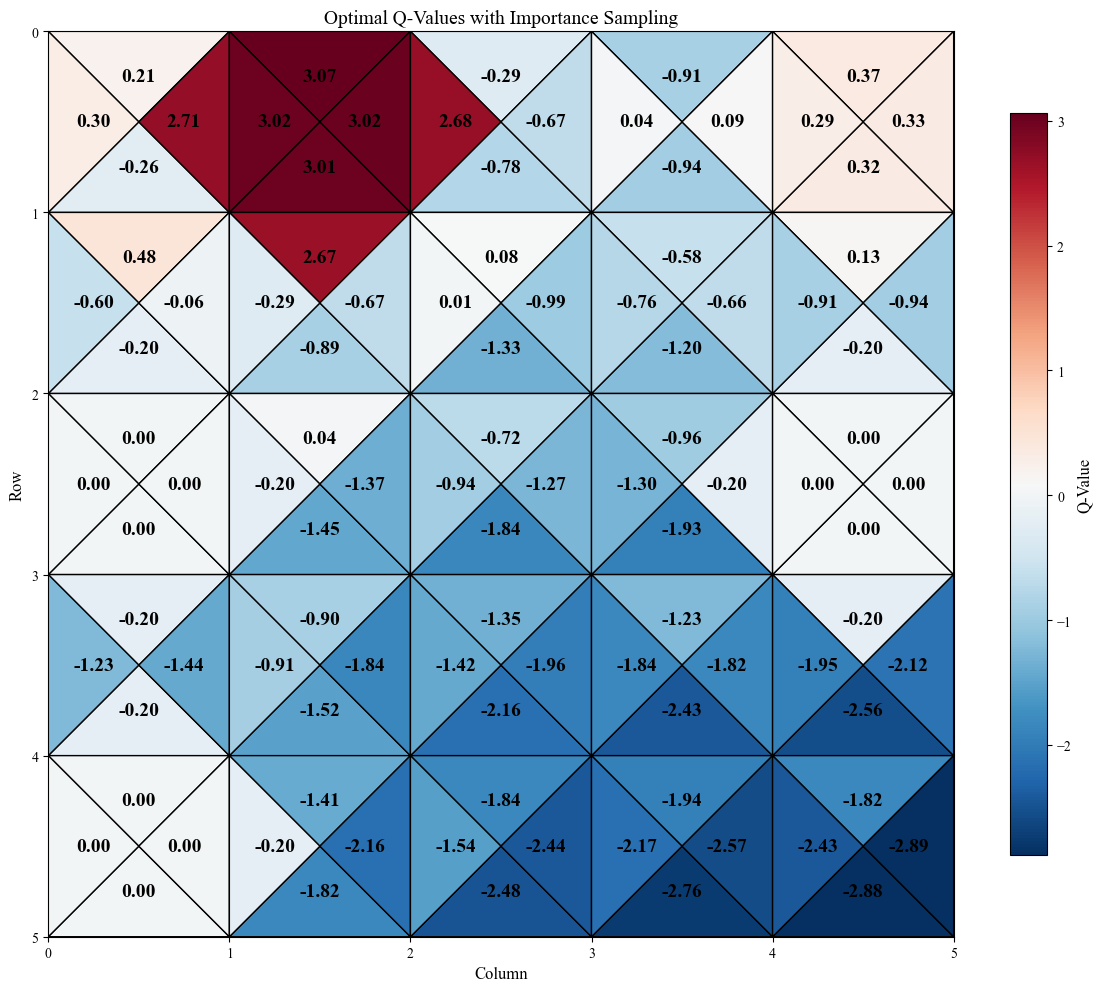

In [7]:
# Plot the Q-values
plot_q_values(optimal_Q_importance_sampling, "Optimal Q-Values with Importance Sampling")